# **Lab 6**

# **Phát hiện bất thường mạng của LSTM Autoencoder**
Trong bài thực hành này, ta sẽ tạo và đào tạo trong LSTM Autoencoder để phát hiện điểm bất thường trên tập dữ liệu  KDD99 về lưu lượng mạng.


# **1. Đọc tập dữ liệu KDD99**

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

from tensorflow.keras.utils import get_file
try:
    path = get_file('kddcup.data_10_percent.gz', origin='http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz')
except:
    print('Error downloading')
    raise

print(path) 

2144903/2144903 [==============================] - 1s 0us/step
/root/.keras/datasets/kddcup.data_10_percent.gz


In [ ]:
df = pd.read_csv(path, header=None)
print("Read {} rows.".format(len(df)))

Read 494021 rows.


In [ ]:
# CSV không có header
df.columns = ['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot',
              'num_failed_logins','logged_in','num_compromised','root_shell', 'su_attempted','num_root','num_file_creations','num_shells',
              'num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate','srv_serror_rate',
              'rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count',
              'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
              'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','outcome']
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


# **2. Xử lý dữ liệu**

In [ ]:
# loại bỏ NA
df.dropna(inplace=True,axis=1) 
df.shape

(494021, 42)

In [ ]:
df.dtypes

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

In [ ]:
df.groupby('outcome')['outcome'].count()

outcome
back.                 2203
buffer_overflow.        30
ftp_write.               8
guess_passwd.           53
imap.                   12
ipsweep.              1247
land.                   21
loadmodule.              9
multihop.                7
neptune.            107201
nmap.                  231
normal.              97278
perl.                    3
phf.                     4
pod.                   264
portsweep.            1040
rootkit.                10
satan.                1589
smurf.              280790
spy.                     2
teardrop.              979
warezclient.          1020
warezmaster.            20
Name: outcome, dtype: int64

# **3. Encode dữ liệu số và chữ**

In [ ]:
# Encode cột số
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd
    
# Encode cột chữ ([1,0,0],[0,1,0],[0,0,1] cho red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

In [ ]:
#encoding feature vector
text_col =['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login', ]

for i in df.columns:
  if i not in text_col:
    if i != 'outcome':
      encode_numeric_zscore(df, i)

for x in text_col:
  encode_text_dummy(df, x)

In [ ]:
df.dropna(inplace=True,axis=1)
df[0:5]

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,flag-S3,flag-SF,flag-SH,land-0,land-1,logged_in-0,logged_in-1,is_host_login-0,is_guest_login-0,is_guest_login-1
0,-0.067792,-0.002879,0.138664,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,0,1,0,1,0,0,1,1,1,0
1,-0.067792,-0.002820,-0.011578,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,0,1,0,1,0,0,1,1,1,0
2,-0.067792,-0.002824,0.014179,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,0,1,0,1,0,0,1,1,1,0
3,-0.067792,-0.002840,0.014179,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,0,1,0,1,0,0,1,1,1,0
4,-0.067792,-0.002842,0.035214,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,0,1,0,1,0,0,1,1,1,0


In [ ]:
df['protocol_type-tcp'].unique()

array([1, 0], dtype=uint8)

In [ ]:
normal_mask = df['outcome']=='normal.'
attack_mask = df['outcome']!='normal.'

df.drop('outcome',axis=1,inplace=True)

df_normal = df[normal_mask]
df_attack = df[attack_mask]

print(f"Normal count: {len(df_normal)}")
print(f"Attack count: {len(df_attack)}")

Normal count: 97278
Attack count: 396743


In [ ]:
# feature vector
x_normal = df_normal.values
x_attack = df_attack.values

In [ ]:
from sklearn.model_selection import train_test_split

x_normal_train, x_normal_test = train_test_split(x_normal, test_size=0.3, random_state=12)

print(f"Normal train count: {len(x_normal_train)}")
print(f"Normal test count: {len(x_normal_test)}")

Normal train count: 68094
Normal test count: 29184


In [ ]:
x_normal_train.shape, x_normal_test.shape

((68094, 120), (29184, 120))

In [ ]:
#Chia tỷ lệ tập dữ liệu
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

x_normal_train = sc.fit_transform(x_normal_train)
x_normal_test = sc.fit_transform(x_normal_test)
x_normal = sc.fit_transform(x_normal)
x_attack = sc.fit_transform(x_attack)

Tập dữ liệu KDD99 không bao gồm timestamps trong thuộc tính. Cho nên ta sẽ xem điểm dữ liệu xảy ra ở timestamps ngay sau điểm dữ liệu trước đó.

In [ ]:
x_normal_train = pd.DataFrame(x_normal_train)
x_normal_test = pd.DataFrame(x_normal_test)
x_attack = pd.DataFrame(x_attack)
x_normal = pd.DataFrame(x_normal)

In [ ]:
#Hàm convert time domain dữ liệu
def create_dataset(X, time_steps):
    Xs = []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
    return np.array(Xs)

In [ ]:
# reshape [samples, time_steps, n_features]

TIME_STEPS = 1
Xnormal_train = create_dataset(x_normal_train, TIME_STEPS)
print(Xnormal_train.shape)

(68093, 1, 120)


In [ ]:
Xnormal_test = create_dataset(x_normal_test, TIME_STEPS)
print(Xnormal_test.shape)

(29183, 1, 120)


In [ ]:
Xattack = create_dataset(x_attack, TIME_STEPS)
print(Xattack.shape)

(396742, 1, 120)


In [ ]:
Xnormal = create_dataset(x_normal,TIME_STEPS)
print(Xattack.shape)

(396742, 1, 120)


# **4. Kiến trúc mô hình LSTM Autoencoder**

In [ ]:
model = keras.Sequential()
model.add(keras.layers.LSTM(units=64, input_shape=(Xnormal_train.shape[1], Xnormal_train.shape[2])))
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.RepeatVector(n=Xnormal_train.shape[1]))
model.add(keras.layers.LSTM(units=32, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=Xnormal_train.shape[2])))

model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                47360     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 repeat_vector (RepeatVector  (None, 1, 64)            0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 1, 32)             12416     
                                                                 
 dropout_1 (Dropout)         (None, 1, 32)             0         
                                                                 
 time_distributed (TimeDistr  (None, 1, 120)           3960      
 ibuted)                                                

# **5. Huấn luyện mô hình**

In [ ]:
history = model.fit(
    Xnormal_train, Xnormal_train,
    epochs=15,
    batch_size=128,
    validation_split=0.2, 
    shuffle = False
)

Epoch 1/15
426/426 [==============================] - 9s 11ms/step - loss: 0.1024 - accuracy: 0.1241 - val_loss: 0.0599 - val_accuracy: 0.2209
Epoch 2/15
426/426 [==============================] - 4s 9ms/step - loss: 0.0632 - accuracy: 0.3115 - val_loss: 0.0500 - val_accuracy: 0.4217
Epoch 3/15
426/426 [==============================] - 4s 9ms/step - loss: 0.0574 - accuracy: 0.3501 - val_loss: 0.0466 - val_accuracy: 0.4312
Epoch 4/15
426/426 [==============================] - 5s 11ms/step - loss: 0.0544 - accuracy: 0.3615 - val_loss: 0.0461 - val_accuracy: 0.4540
Epoch 5/15
426/426 [==============================] - 4s 9ms/step - loss: 0.0529 - accuracy: 0.3655 - val_loss: 0.0453 - val_accuracy: 0.4558
Epoch 6/15
426/426 [==============================] - 4s 9ms/step - loss: 0.0520 - accuracy: 0.3750 - val_loss: 0.0447 - val_accuracy: 0.4570
Epoch 7/15
426/426 [==============================] - 4s 9ms/step - loss: 0.0511 - accuracy: 0.4012 - val_loss: 0.0440 - val_accuracy: 0.5050
Epoc

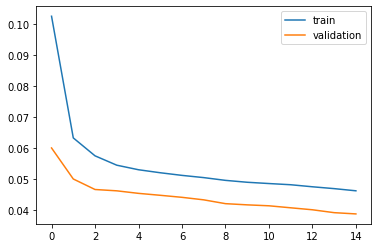

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend();

# **6. Đánh giá mô hình**

In [ ]:
X_train_pred = model.predict(Xnormal_train)

train_mae_loss = np.mean(np.abs(X_train_pred - Xnormal_train), axis=1)
train_mae_loss.shape

2128/2128 [==============================] - 6s 2ms/step


(68093, 120)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


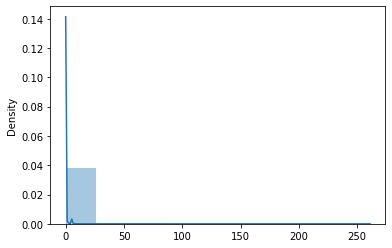

In [ ]:
sns.distplot(train_mae_loss, bins=10, kde=True);

In [ ]:
X_normal_pred = model.predict(Xnormal)

normal_mae_loss = np.mean(np.abs(X_normal_pred - Xnormal), axis=1)
normal_mae_loss.shape

3040/3040 [==============================] - 9s 3ms/step


(97277, 120)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


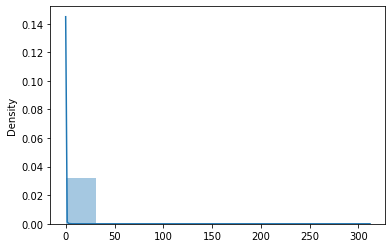

In [ ]:
sns.distplot(normal_mae_loss, bins=10, kde=True);

In [ ]:
score1 = model.evaluate(Xnormal_train, Xnormal_train)
print("\n Sample Loss(MAE) & Accuracy Scores (Train):", score1[0], score1[1], "\n") 

score2 = model.evaluate(Xnormal_test, Xnormal_test)
print("\nOut of Sample Loss(MAE) & Accuracy Scores (Test):", score2[0], score2[1], "\n") 

score3 = model.evaluate(Xattack, Xattack)
print("\nAttack Underway Loss(MAE) & Accuracy Scores (Anomaly):", score3[0], score3[1], "\n") 

2128/2128 [==============================] - 5s 3ms/step - loss: 0.0383 - accuracy: 0.5968

 Sample Loss(MAE) & Accuracy Scores (Train): 0.03826780989766121 0.5968161225318909 

912/912 [==============================] - 3s 3ms/step - loss: 0.0403 - accuracy: 0.6001

Out of Sample Loss(MAE) & Accuracy Scores (Test): 0.040309056639671326 0.6001096367835999 

12399/12399 [==============================] - 34s 3ms/step - loss: 0.1613 - accuracy: 0.7143

Attack Underway Loss(MAE) & Accuracy Scores (Anomaly): 0.1613328605890274 0.7143458724021912 



Kết luận: Độ chính xác của mô hình dự đoán trên tập normal train và set đạt 0,57. Trong khi đó độ chính xác của mô hình khi được huấn luyện trên cả 2 tập normal và attack đạt 0,66.
Sai số - Mean Absolute Error (mae). Dữ liệu normal ở train và test có mae khoảng 0,04 và dữ liệu attack là 0,16

# **7. Bài tập**
**Sinh viên chạy lại tập dữ liệu [CIC IDS 2018](https://www.unb.ca/cic/datasets/ids-2018.html) trên mô hình bài lab này.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.utils import class_weight

RANDOM_STATE_SEED = 12

In [77]:
df_dataset = pd.read_csv("/content/drive/MyDrive/MLATTL/Dataset_Lab5/02-14-2018.csv")


In [78]:
# display data
df_dataset

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,14/02/2018 08:31:01,112641719,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56320859.5,139.300036,56320958,56320761,Benign
1,0,0,14/02/2018 08:33:50,112641466,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56320733.0,114.551299,56320814,56320652,Benign
2,0,0,14/02/2018 08:36:39,112638623,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56319311.5,301.934596,56319525,56319098,Benign
3,22,6,14/02/2018 08:40:13,6453966,15,10,1239,2273,744,0,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
4,22,6,14/02/2018 08:40:23,8804066,14,11,1143,2209,744,0,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,80,6,14/02/2018 10:53:23,10156986,5,5,1089,1923,587,0,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
1048571,80,6,14/02/2018 10:53:33,117,2,0,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
1048572,80,6,14/02/2018 10:53:28,5095331,3,1,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
1048573,80,6,14/02/2018 10:53:28,5235511,3,1,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign


In [79]:
# feature information
df_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 80 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Dst Port           1048575 non-null  int64  
 1   Protocol           1048575 non-null  int64  
 2   Timestamp          1048575 non-null  object 
 3   Flow Duration      1048575 non-null  int64  
 4   Tot Fwd Pkts       1048575 non-null  int64  
 5   Tot Bwd Pkts       1048575 non-null  int64  
 6   TotLen Fwd Pkts    1048575 non-null  int64  
 7   TotLen Bwd Pkts    1048575 non-null  int64  
 8   Fwd Pkt Len Max    1048575 non-null  int64  
 9   Fwd Pkt Len Min    1048575 non-null  int64  
 10  Fwd Pkt Len Mean   1048575 non-null  float64
 11  Fwd Pkt Len Std    1048575 non-null  float64
 12  Bwd Pkt Len Max    1048575 non-null  int64  
 13  Bwd Pkt Len Min    1048575 non-null  int64  
 14  Bwd Pkt Len Mean   1048575 non-null  float64
 15  Bwd Pkt Len Std    1048575 non-n

In [80]:
# replace +ve and -ve infinity with NaN
df_dataset.replace([np.inf, -np.inf], np.nan, inplace=True)

In [81]:
df_dataset.describe()

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,...,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06
mean,4.876262e+03,8.107557e+00,6.255555e+06,6.206622e+00,7.211191e+00,4.479936e+02,4.521803e+03,1.745736e+02,8.389535e+00,3.879579e+01,...,2.793536e+00,2.327970e+01,5.152449e+04,2.136151e+04,8.789157e+04,3.995477e+04,3.101206e+06,7.297218e+05,4.812391e+06,2.126920e+06
std,1.444344e+04,4.460625e+00,1.260291e+09,4.447851e+01,1.048682e+02,1.573541e+04,1.515021e+05,2.876713e+02,1.948279e+01,5.331882e+01,...,5.557106e+00,1.106185e+01,5.815586e+05,2.186405e+05,7.395725e+05,5.602693e+05,5.414780e+08,3.820031e+08,1.522117e+09,1.817013e+07
min,0.000000e+00,0.000000e+00,-9.190110e+11,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.200000e+01,6.000000e+00,7.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.300000e+01,6.000000e+00,1.023000e+03,2.000000e+00,1.000000e+00,3.600000e+01,5.500000e+01,3.400000e+01,0.000000e+00,2.566667e+01,...,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.430000e+02,6.000000e+00,4.066690e+05,7.000000e+00,6.000000e+00,4.550000e+02,7.680000e+02,1.990000e+02,0.000000e+00,5.550000e+01,...,4.000000e+00,3.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,6.553300e+04,1.700000e+01,1.200000e+08,5.115000e+03,9.198000e+03,8.591554e+06,1.339773e+07,6.444000e+04,1.460000e+03,1.121703e+04,...,1.031000e+03,4.800000e+01,1.102401e+08,5.723446e+07,1.102401e+08,1.102401e+08,3.394503e+11,2.432682e+11,9.797810e+11,1.260300e+10


In [82]:
# drop missing values
df_dataset.dropna(inplace=True)

In [83]:
df_dataset

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,14/02/2018 08:31:01,112641719,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56320859.5,139.300036,56320958,56320761,Benign
1,0,0,14/02/2018 08:33:50,112641466,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56320733.0,114.551299,56320814,56320652,Benign
2,0,0,14/02/2018 08:36:39,112638623,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56319311.5,301.934596,56319525,56319098,Benign
3,22,6,14/02/2018 08:40:13,6453966,15,10,1239,2273,744,0,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
4,22,6,14/02/2018 08:40:23,8804066,14,11,1143,2209,744,0,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,80,6,14/02/2018 10:53:23,10156986,5,5,1089,1923,587,0,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
1048571,80,6,14/02/2018 10:53:33,117,2,0,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
1048572,80,6,14/02/2018 10:53:28,5095331,3,1,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
1048573,80,6,14/02/2018 10:53:28,5235511,3,1,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign


In [84]:
df_dataset["Label"].value_counts()

Benign            663808
FTP-BruteForce    193354
SSH-Bruteforce    187589
Name: Label, dtype: int64

In [85]:
df = df_dataset

In [86]:
from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
import plotly.express as px
init_notebook_mode(connected=True)
import plotly.graph_objs as go

fig = go.Figure(data=[
    go.Bar(name='Benign', 
           y=df["Label"].value_counts().values[0:1],
           x=['Benign'],
           text = df["Label"].value_counts()[0:1],
           orientation='v',
           textposition='outside',),
    go.Bar(name='FTP-BruteForce', 
           y=df["Label"].value_counts().values[1:2],
           x=['FTP-BruteForce'],
           text = df["Label"].value_counts()[1:2],
           orientation='v',
           textposition='outside',),

    go.Bar(name='SSH-Bruteforce', 
           y=df["Label"].value_counts().values[2:],
           x=['SSH-Bruteforce'],
           text = df["Label"].value_counts()[2:],
           orientation='v',
           textposition='outside',)
])
# Change the bar mode
fig.update_layout(
                  width=900,
                  height=500,
                  title=f'Class Distribution',
                  yaxis_title='Number of attacks',
                  xaxis_title='Attack Name',)
fig.show(renderer="colab")

In [87]:
df.replace(to_replace=["FTP-BruteForce", "SSH-Bruteforce"], value="Malicious", inplace=True)

In [88]:
df_dataset["Label"].value_counts()


Benign       663808
Malicious    380943
Name: Label, dtype: int64

In [89]:
fig = go.Figure(data=[
    go.Bar(name='Benign', 
           y=df["Label"].value_counts().values[0:1],
           x=['Benign'],
           text = df["Label"].value_counts()[0:1],
           orientation='v',
           textposition='outside',),
    go.Bar(name='Malicious', 
           y=df["Label"].value_counts().values[1:2],
           x=['Malicious'],
           text = df["Label"].value_counts()[1:2],
           orientation='v',
           textposition='outside',)
])
# Change the bar mode
fig.update_layout(
                  width=800,
                  height=600,
                  title=f'Class Distribution',
                  yaxis_title='Number of attacks',
                  xaxis_title='Attack Name',)
fig.show(renderer="colab")


In [90]:
df1 = df[df["Label"] == "Benign"][:663808]
df2 = df[df["Label"] == "Malicious"][:380943]
df_equal = pd.concat([ df1,df2], axis =0)

In [91]:
df_equal.replace(to_replace="Benign", value=0, inplace=True)
df_equal.replace(to_replace="Malicious", value=1, inplace=True)

In [92]:
train, test = train_test_split(df_equal, test_size=0.3, random_state=RANDOM_STATE_SEED)

In [93]:
# display columns
train.columns

Index(['Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Tot Fwd Pkts',
       'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
      

In [94]:
# feature info
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 731325 entries, 898216 to 856545
Data columns (total 80 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Dst Port           731325 non-null  int64  
 1   Protocol           731325 non-null  int64  
 2   Timestamp          731325 non-null  object 
 3   Flow Duration      731325 non-null  int64  
 4   Tot Fwd Pkts       731325 non-null  int64  
 5   Tot Bwd Pkts       731325 non-null  int64  
 6   TotLen Fwd Pkts    731325 non-null  int64  
 7   TotLen Bwd Pkts    731325 non-null  int64  
 8   Fwd Pkt Len Max    731325 non-null  int64  
 9   Fwd Pkt Len Min    731325 non-null  int64  
 10  Fwd Pkt Len Mean   731325 non-null  float64
 11  Fwd Pkt Len Std    731325 non-null  float64
 12  Bwd Pkt Len Max    731325 non-null  int64  
 13  Bwd Pkt Len Min    731325 non-null  int64  
 14  Bwd Pkt Len Mean   731325 non-null  float64
 15  Bwd Pkt Len Std    731325 non-null  float64
 1

In [95]:
min_max_scaler = MinMaxScaler().fit(train[['Flow Duration', 'Tot Fwd Pkts',
       'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
       'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Fwd Byts/b Avg',
       'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg',
       'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg', 'Subflow Fwd Pkts',
       'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts',
       'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts',
       'Fwd Seg Size Min', 'Active Mean', 'Active Std', 'Active Max',
       'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min']])

In [96]:
numerical_columns = ['Flow Duration', 'Tot Fwd Pkts',
       'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
       'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Fwd Byts/b Avg',
       'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg',
       'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg', 'Subflow Fwd Pkts',
       'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts',
       'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts',
       'Fwd Seg Size Min', 'Active Mean', 'Active Std', 'Active Max',
       'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min']

In [97]:
train[numerical_columns] = min_max_scaler.transform(train[numerical_columns])

In [98]:
train

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
898216,53,17,14/02/2018 01:09:47,0.999869,0.000196,0.000221,0.000009,0.000014,0.000590,0.031276,...,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
930017,53,17,14/02/2018 09:51:40,0.999869,0.000000,0.000111,0.000005,0.000008,0.000636,0.033745,...,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
388400,53,17,14/02/2018 11:48:15,0.999869,0.000196,0.000221,0.000010,0.000016,0.000652,0.034568,...,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
671818,80,6,14/02/2018 12:04:07,0.999869,0.000391,0.000442,0.000019,0.000037,0.002498,0.000000,...,0.416667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
508196,443,6,14/02/2018 12:55:59,0.999869,0.000391,0.000000,0.000009,0.000000,0.000714,0.000000,...,0.416667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
948670,53,17,14/02/2018 01:51:10,0.999869,0.000000,0.000111,0.000005,0.000004,0.000652,0.034568,...,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
796126,3389,6,14/02/2018 01:21:55,0.999872,0.001369,0.000774,0.000131,0.000120,0.010258,0.000000,...,0.416667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
637768,80,6,14/02/2018 10:49:13,0.999929,0.000196,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.416667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
95760,21,6,14/02/2018 11:21:28,0.999869,0.000000,0.000111,0.000000,0.000000,0.000000,0.000000,...,0.833333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [99]:
train.describe()

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
count,731325.000000,731325.000000,731325.000000,731325.000000,731325.000000,731325.000000,731325.000000,731325.000000,731325.000000,731325.000000,...,731325.000000,731325.000000,731325.000000,731325.000000,731325.000000,731325.000000,731325.000000,731325.000000,731325.000000,731325.000000
mean,4707.674622,8.116218,0.999876,0.001020,0.000793,0.000054,0.000336,0.002719,0.006926,0.003469,...,0.485254,0.000468,0.000378,0.000804,0.000362,0.000009,0.000003,0.000005,0.000168,0.364642
std,14199.091144,4.467026,0.001497,0.008766,0.011379,0.002191,0.011261,0.004566,0.015975,0.004867,...,0.230808,0.005301,0.004018,0.006814,0.005092,0.001525,0.001493,0.001476,0.001582,0.481330
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.000000,6.000000,0.999869,0.000000,0.000111,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.416667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,53.000000,6.000000,0.999869,0.000196,0.000111,0.000004,0.000004,0.000543,0.000000,0.002288,...,0.416667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,443.000000,6.000000,0.999870,0.001369,0.000664,0.000053,0.000060,0.003119,0.000000,0.004992,...,0.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,65533.000000,17.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [100]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 731325 entries, 898216 to 856545
Data columns (total 80 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Dst Port           731325 non-null  int64  
 1   Protocol           731325 non-null  int64  
 2   Timestamp          731325 non-null  object 
 3   Flow Duration      731325 non-null  float64
 4   Tot Fwd Pkts       731325 non-null  float64
 5   Tot Bwd Pkts       731325 non-null  float64
 6   TotLen Fwd Pkts    731325 non-null  float64
 7   TotLen Bwd Pkts    731325 non-null  float64
 8   Fwd Pkt Len Max    731325 non-null  float64
 9   Fwd Pkt Len Min    731325 non-null  float64
 10  Fwd Pkt Len Mean   731325 non-null  float64
 11  Fwd Pkt Len Std    731325 non-null  float64
 12  Bwd Pkt Len Max    731325 non-null  float64
 13  Bwd Pkt Len Min    731325 non-null  float64
 14  Bwd Pkt Len Mean   731325 non-null  float64
 15  Bwd Pkt Len Std    731325 non-null  float64
 1

In [101]:
train.drop(['Timestamp'], axis=1,inplace=True)
test.drop(['Timestamp'],axis=1,inplace=True)

In [102]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 731325 entries, 898216 to 856545
Data columns (total 79 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Dst Port           731325 non-null  int64  
 1   Protocol           731325 non-null  int64  
 2   Flow Duration      731325 non-null  float64
 3   Tot Fwd Pkts       731325 non-null  float64
 4   Tot Bwd Pkts       731325 non-null  float64
 5   TotLen Fwd Pkts    731325 non-null  float64
 6   TotLen Bwd Pkts    731325 non-null  float64
 7   Fwd Pkt Len Max    731325 non-null  float64
 8   Fwd Pkt Len Min    731325 non-null  float64
 9   Fwd Pkt Len Mean   731325 non-null  float64
 10  Fwd Pkt Len Std    731325 non-null  float64
 11  Bwd Pkt Len Max    731325 non-null  float64
 12  Bwd Pkt Len Min    731325 non-null  float64
 13  Bwd Pkt Len Mean   731325 non-null  float64
 14  Bwd Pkt Len Std    731325 non-null  float64
 15  Flow Byts/s        731325 non-null  float64
 1

In [103]:
test[numerical_columns] = min_max_scaler.transform(test[numerical_columns])

In [104]:
test[numerical_columns]

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,...,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
935143,0.999869,0.000000,0.000111,3.608195e-06,0.000005,0.000481,0.025514,0.002764,0.000000,0.043151,...,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.00000,0.000000
1010509,0.999870,0.000196,0.000000,1.163934e-07,0.000000,0.000016,0.000000,0.000045,0.000045,0.000000,...,0.000000,0.416667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.00000,0.000000
140044,0.999869,0.000000,0.000111,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.833333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.00000,0.000000
1022634,0.999869,0.000000,0.000111,4.190162e-06,0.000012,0.000559,0.029630,0.003209,0.000000,0.112329,...,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.00000,0.000000
84189,0.999869,0.000000,0.000111,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.833333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521789,0.999869,0.000000,0.000111,4.306555e-06,0.000006,0.000574,0.030453,0.003299,0.000000,0.052740,...,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.00000,0.000000
959406,0.999875,0.000587,0.000442,1.129016e-05,0.000018,0.001505,0.000000,0.002162,0.003077,0.158904,...,0.000970,0.416667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.00000,0.000000
106142,0.999869,0.000000,0.000111,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.833333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.00000,0.000000
518903,0.999998,0.009973,0.009954,1.189540e-04,0.008821,0.003880,0.000000,0.001752,0.003496,1.000000,...,0.007759,0.416667,0.008011,0.019896,0.015315,0.000707,0.000172,3.778443e-07,0.00006,0.004616


In [105]:
test.describe()

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
count,313426.000000,313426.000000,313426.000000,313426.000000,313426.000000,313426.000000,313426.000000,313426.000000,313426.000000,313426.000000,...,313426.000000,313426.000000,313426.000000,313426.000000,313426.000000,313426.000000,313426.000000,313426.000000,313426.000000,313426.000000
mean,4720.909449,8.113063,0.999877,0.001023,0.000818,0.000049,0.000363,0.002717,0.006935,0.003469,...,0.485212,0.000471,0.000366,0.000791,0.000367,0.000010,0.000003,0.000005,0.000172,0.364587
std,14218.949701,4.466794,0.001030,0.008589,0.012160,0.000143,0.012057,0.004237,0.016251,0.004496,...,0.230909,0.005248,0.003340,0.006499,0.005091,0.001756,0.001746,0.001729,0.001057,0.481315
min,0.000000,0.000000,0.423454,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.000000,6.000000,0.999869,0.000000,0.000111,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.416667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,53.000000,6.000000,0.999869,0.000196,0.000111,0.000004,0.000004,0.000543,0.000000,0.002288,...,0.416667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,443.000000,6.000000,0.999870,0.001369,0.000664,0.000053,0.000060,0.003119,0.000000,0.004992,...,0.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,65530.000000,17.000000,1.000000,0.965976,1.017253,0.050079,1.015598,0.022657,1.201646,0.130159,...,0.833333,0.916304,0.280814,0.916304,0.916304,0.983224,0.977323,0.968003,0.389431,1.000000


In [106]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 313426 entries, 935143 to 622984
Data columns (total 79 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Dst Port           313426 non-null  int64  
 1   Protocol           313426 non-null  int64  
 2   Flow Duration      313426 non-null  float64
 3   Tot Fwd Pkts       313426 non-null  float64
 4   Tot Bwd Pkts       313426 non-null  float64
 5   TotLen Fwd Pkts    313426 non-null  float64
 6   TotLen Bwd Pkts    313426 non-null  float64
 7   Fwd Pkt Len Max    313426 non-null  float64
 8   Fwd Pkt Len Min    313426 non-null  float64
 9   Fwd Pkt Len Mean   313426 non-null  float64
 10  Fwd Pkt Len Std    313426 non-null  float64
 11  Bwd Pkt Len Max    313426 non-null  float64
 12  Bwd Pkt Len Min    313426 non-null  float64
 13  Bwd Pkt Len Mean   313426 non-null  float64
 14  Bwd Pkt Len Std    313426 non-null  float64
 15  Flow Byts/s        313426 non-null  float64
 1

In [107]:
print("Full dataset:\n")
print("Benign: " + str(df["Label"].value_counts()[[0]].sum()))
print("Malicious: " + str(df["Label"].value_counts()[[1]].sum()))
print("---------------")

print("Training set:\n")
print("Benign: " + str(train["Label"].value_counts()[[0]].sum()))
print("Malicious: " + str(train["Label"].value_counts()[[1]].sum()))
print("---------------")

print("Test set:\n")
print("Benign: " + str(test["Label"].value_counts()[[0]].sum()))
print("Malicious: " + str(test["Label"].value_counts()[[1]].sum()))

Full dataset:

Benign: 663808
Malicious: 380943
---------------
Training set:

Benign: 464653
Malicious: 266672
---------------
Test set:

Benign: 199155
Malicious: 114271


In [108]:
y_train = train.pop("Label")
X_train = train.values
y_test = test.pop("Label")
X_test = test.values


y_test

935143     0
1010509    0
140044     1
1022634    0
84189      1
          ..
521789     0
959406     0
106142     1
518903     0
622984     0
Name: Label, Length: 313426, dtype: int64

In [109]:
y_train

898216    0
930017    0
388400    0
671818    0
508196    0
         ..
948670    0
796126    0
637768    0
95760     1
856545    0
Name: Label, Length: 731325, dtype: int64

In [110]:
def freq_count(data):
    mp = dict();
    for i in data:
        if i in mp:
            mp[i] = mp[i]+1
        else:
            mp[i] = 1
    return mp

y_train[y_train == 1] = -1
y_train[y_train == 0] = 1
print(freq_count(y_train))

y_test[y_test == 1] = -1
y_test[y_test == 0] = 1
freq_count(y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



{1: 464653, -1: 266672}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



{1: 199155, -1: 114271}

In [111]:
from sklearn.ensemble import IsolationForest
iFM = IsolationForest(
    n_estimators = 100,
    max_samples = "auto",
    random_state = 42,
    warm_start = False
)

In [112]:
hyperparameters = {
    'n_estimators': [50, 75, 100, 125, 150]
}

isolationForestCV = GridSearchCV(
    estimator=iFM,
    scoring = 'accuracy',
    param_grid=hyperparameters,
    cv=5,
    verbose=1,
    n_jobs=-1  # Use all available CPU cores
)

In [113]:
isolationForestCV.fit(X = X_train, y = y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5, estimator=IsolationForest(random_state=42), n_jobs=-1,
             param_grid={'n_estimators': [50, 75, 100, 125, 150]},
             scoring='accuracy', verbose=1)

In [114]:
print("Accuracy score on Validation set: \n")
print(isolationForestCV.best_score_ )
print("---------------")
print("Best performing hyperparameters on Validation set: ")
print(isolationForestCV.best_params_)
print("---------------")
print(isolationForestCV.best_estimator_)

Accuracy score on Validation set: 

0.5514907872696817
---------------
Best performing hyperparameters on Validation set: 
{'n_estimators': 75}
---------------
IsolationForest(n_estimators=75, random_state=42)


In [115]:
model = isolationForestCV.best_estimator_

In [116]:
model

IsolationForest(n_estimators=75, random_state=42)

In [117]:
predictions = model.predict(X_test)
freq_count(predictions)

{1: 287860, -1: 25566}

In [118]:
print(accuracy_score(y_test, predictions))

0.5538436504948536


In [119]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, predictions)
cf_matrix

array([[     0, 114271],
       [ 25566, 173589]])

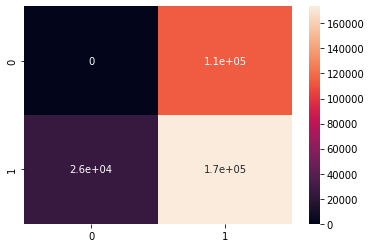

In [120]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)